In [1]:
#!pip install celery

In [2]:
#!sudo rabbitmqctl add_user myguest myguestpwd
#!sudo rabbitmqctl set_permissions -p / myguest "." "." ".*"

In [3]:
# On the workers you will neeed to run:
#celery -A kmeans_workers_v2 worker --loglevel=info --concurrency=4


In [4]:
!sudo rabbitmqctl list_users

Listing users ...
guest	[administrator]
myguest	[]


In [5]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.datasets import make_blobs
from copy import deepcopy

from celery import group
from kmeans_workers_v2 import kmeans_tasks, dist, NumpyEncoder


In [6]:
n_samples=16000
n_clusters=3
n_features =2
n_workers = 4 #Check the celery also uses 4 workers!!!

In [7]:
np.random.seed(seed=1023)

In [8]:
# Creating a n_features=2 Dim dataset with centers=3 clusters
Xs, Ys = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, shuffle =False)

In [9]:
Ys

array([0, 0, 0, ..., 2, 2, 2])

In [10]:
mydata= [{"points": x, "label": y} for x,y in zip(Xs,Ys)]

In [11]:
print(len(mydata))
print(mydata[15]['points'],mydata[15]['label'])

16000
[7.4123751  1.65861249] 0


In [12]:
# Split the sequence in a number of chunks and process those independently.

if 1:
    l = n_samples // n_workers
    Xsubseqs = [mydata[i * l:(i + 1) * l] for i in range(n_workers - 1)]
    Xsubseqs.append(mydata[(n_workers - 1) * l:])
else:
    splitting_points=[100,300,1000]
    Xsubseqs=[]
    Xsubseqs.append(mydata[0:splitting_points[0]])
    Xsubseqs.append(mydata[splitting_points[0]:splitting_points[1]])
    Xsubseqs.append(mydata[splitting_points[1]:splitting_points[2]])
    Xsubseqs.append(mydata[splitting_points[2]:])
    
for i in range(len(Xsubseqs)):
    print(len(Xsubseqs[i]))

4000
4000
4000
4000


In [13]:
np.matrix(np.diag(np.max(Xs,0)))

matrix([[11.87536783,  0.        ],
        [ 0.        ,  8.26562541]])

In [14]:
C=np.matrix(np.random.rand(n_clusters,n_features))*np.matrix(np.diag(np.max(Xs,0)))
print("Initial Centroids")
print(C)


Initial Centroids
[[10.71854272  0.65915336]
 [ 1.78003584  8.22716699]
 [ 3.07457675  0.19630368]]


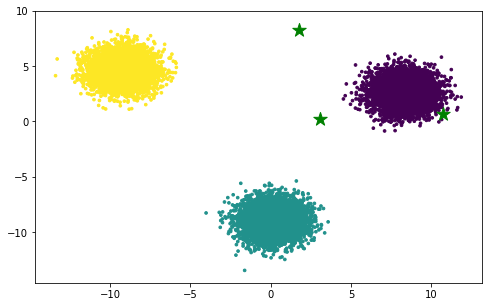

In [15]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)
fig = plt.figure()

# Plotting along with the Centroids
#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata])
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata],c=[actdata['label'] for actdata in mydata], s=7)

plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


In [16]:
len([actdata['label'] for actdata in mydata])

16000

In [17]:
print(C)
print(C.shape)

[[10.71854272  0.65915336]
 [ 1.78003584  8.22716699]
 [ 3.07457675  0.19630368]]
(3, 2)


### Distributed Kmeans

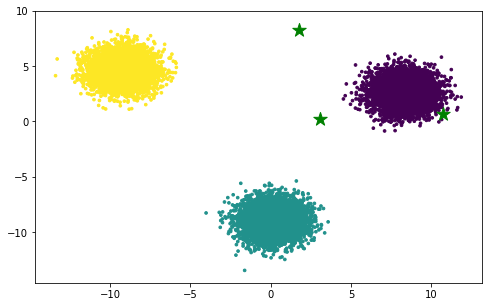

In [18]:
# Split the sequence in a number of chunks and process those independently.
n_iter =15

l = n_samples // n_workers
Xsubseqs = [mydata[i * l:(i + 1) * l] for i in range(n_workers - 1)]
Xsubseqs.append(mydata[(n_workers - 1) * l:])
C_start=C

#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c='#050505', s=7)
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata],c=[actdata['label'] for actdata in mydata], s=7)
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


In [19]:
#Let us upload data to the workers
response = group(kmeans_tasks.s(task='data_to_workers', json_dump = json.dumps({'C': C, 'X': seq,'n_clusters': n_clusters, 'n_features':n_features}, cls=NumpyEncoder)) 
                                               for seq in Xsubseqs)() 

response.get()

['success', 'success', 'success', 'success']

In [20]:
starttime = time.time()
for iter in range(0, n_iter): 
    lazy_partials_EMstep = group(kmeans_tasks.s(task='EM_step', json_dump = json.dumps({'C': C}, cls=NumpyEncoder)) 
                                                   for seq in Xsubseqs)() 
    # call remote workers to run the sort task 
    partials_EMstep = lazy_partials_EMstep.get() # will wait for the tasks to return
    
    #all wrokers are done with their tasks
    partials_C=[json.loads(seq)['C'] for seq in partials_EMstep]
    print(partials_C)
    partials_num_points=[json.loads(seq)['num_points'] for seq in partials_EMstep]
    print(partials_num_points)
    
    #aggregation by th server
    C=np.zeros([n_clusters,n_features])
    for i in range(n_clusters):
        for j in range(n_workers):
             C[i,:]=C[i,:]+partials_num_points[j][i]*np.array(partials_C[j][i])

    num_points=np.sum(np.array(partials_num_points),0)
    print('num_points in clusters:', num_points)
    
    for i in range(n_clusters):
        if num_points[i]>0:
            C[i,:]=C[i,:]/num_points[i]

endtime = time.time()
print('Elapsed time: ', endtime - starttime)

[[[8.422201304088736, 2.6137436023380736], [6.0830017974925505, 4.872941427712554], [0.37764734450389476, -8.608710105834328]], [[0.0, 0.0], [-9.22991932979151, 4.711467969692619], [0.1396340542537892, -8.890482676200586]], [[0.0, 0.0], [-9.215115564709178, 4.669287194691149], [-8.886312637602137, 2.016207718473176]], [[8.42358707932165, 2.6050844602753407], [6.370725958008974, 5.334069570754201], [6.294195331439151, 2.5171262705996598]]]
[[1249, 1, 2750], [0, 1320, 2680], [0, 3957, 43], [3747, 4, 249]]
num_points in clusters: [4996 5282 5722]
[[[8.293866377063882, 2.612164071481718], [0.0, 0.0], [0.18751871004756937, -8.960668027626799]], [[0.0, 0.0], [-9.220075446388815, 4.68601011155831], [0.18038482193912803, -8.94405974163125]], [[8.288979581894651, 2.602338048078514], [0.0, 0.0], [0.0, 0.0]], [[0.0, 0.0], [-9.211580933242773, 4.640766590321808], [0.0, 0.0]]]
[[1334, 0, 2666], [0, 1333, 2667], [4000, 0, 0], [0, 4000, 0]]
num_points in clusters: [5334 5333 5333]
[[[8.28897958189465

In [21]:
partials_num_points

[[1334, 0, 2666], [0, 1333, 2667], [0, 4000, 0], [4000, 0, 0]]

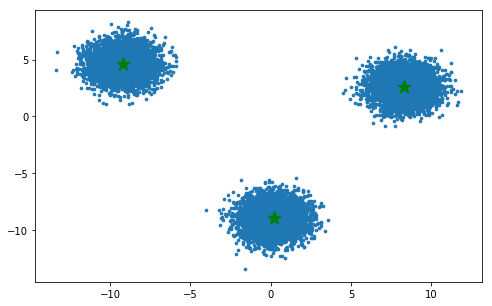

In [22]:
plt.rcParams['figure.figsize'] = (8, 5)
fig = plt.figure()
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata], s=7)

plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')
plt.show()


### Standard non-distributed kMeans clustering running on the server

**Let us compare the running time of the distributed kmeans with the non-distributed kmeans 

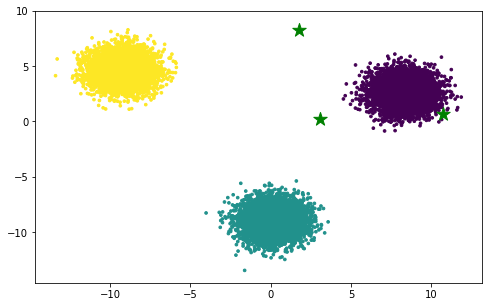

In [23]:
C=C_start # start it from the same starting point

#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c='#050505', s=7)
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata],c=[actdata['label'] for actdata in mydata], s=7)
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


In [24]:
# Set up variable X in the kmeans_tasks function
kmeans_tasks(task='data_to_workers', json_dump = json.dumps({'C': C, 'X': mydata,'n_clusters': n_clusters, 
                                                                        'n_features':n_features}, cls=NumpyEncoder)) 

n_clusters: 3
n_features: 2


'success'

In [25]:
starttime = time.time()
for iter in range(0, n_iter): 
    results=kmeans_tasks(task='EM_step', json_dump = json.dumps({'C': C}, cls=NumpyEncoder)) 
    C=np.array(json.loads(results)['C'])
endtime = time.time()
print('Elapsed time: ', endtime - starttime)

*** we are in the E-Step ***
E step iter: 1
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the E-Step ***
E step iter: 2
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the E-Step ***
E step iter: 3
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the E-Step ***
E step iter: 4
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the E-Step ***
E step iter: 5
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the E-Step ***
E step iter: 6
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the E-Step ***
E step iter: 7
 *** Labels updated.

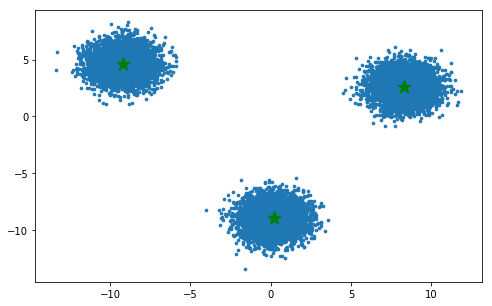

In [26]:
plt.rcParams['figure.figsize'] = (8, 5)
fig = plt.figure()
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata], s=7)

plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')
plt.show()
